# FOPRA 109 Analysis Code: Spectrum Analysis

Please execute all code blocks sequentially. The analysis data must be save in ./FOPRA_109

Please modify the get_data_paths functions in ./utils.py to adapt for your data structure

In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import utils
from utils import get_data_paths, rebin_histogram

data_path = "./FOPRA_109"

def draw_energy_histogram(ax, weights, edges, ch_nmr, xlabel="ADC Counts", ylabel="Counts"):
    """Draw a given histogram in a matplotlib axis object ax"""
    ax.stairs(weights, edges, label=f"Ch_{ch_nmr}")
    ax.set_xlim(edges.min(), edges.max())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale("log")
    ax.legend()

def draw_all_channels(axs, run_nmr, adc_range, rebin, calibration=None, xlabel="ADC Counts", ylabel="Counts"):
    """Draw the energy spectra of all channels"""
    files = get_data_paths(data_path, run_nmr, "txt")
    weights_holder = []
    edges_holder = []
    for ch_nmr, file in enumerate(files):
        if ch_nmr == 7:
            continue
        weights = np.loadtxt(file)[adc_range[0]:adc_range[1]]
        weights, edges = rebin_histogram(weights, np.arange(len(weights)) + adc_range[0], rebin)

        if calibration is not None:
            edges = edges * calibration[f"ch{ch_nmr}"]["param"][0] + calibration[f"ch{ch_nmr}"]["param"][1]

        weights_holder.append(weights.tolist())
        edges_holder.append(edges.tolist())

        if ch_nmr == 6:
            draw_energy_histogram(axs[-1, -2], weights, edges, ch_nmr, xlabel, ylabel)
        else:
            draw_energy_histogram(axs[ch_nmr // 3, ch_nmr % 3], weights, edges, ch_nmr, xlabel, ylabel)

    return np.array(weights_holder), np.array(edges_holder)

### Uncalibrated spectra

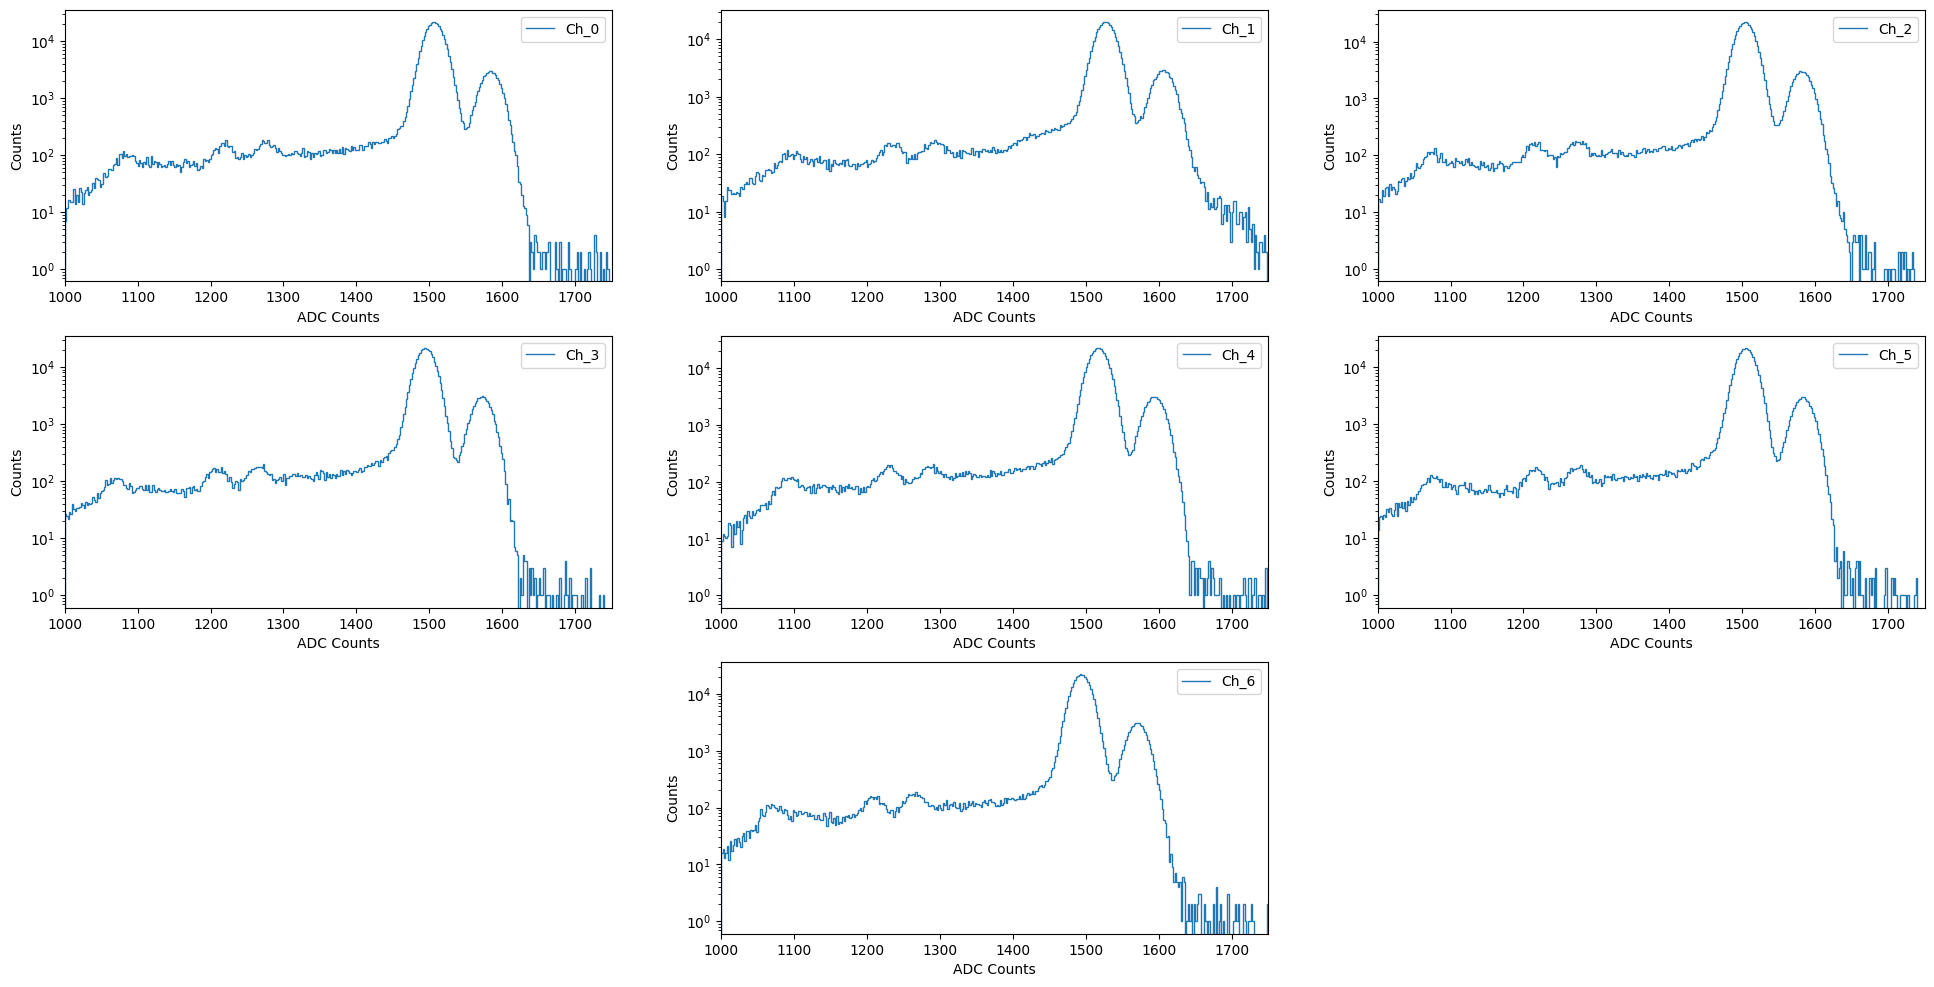

In [2]:
fig = plt.figure(figsize=(24, 12))
ax = fig.subplots(3, 3)

weights, edges = draw_all_channels(ax, 1, (1000, 1750), 2)
fig.delaxes(ax[-1,-1])
fig.delaxes(ax[-1,-3])

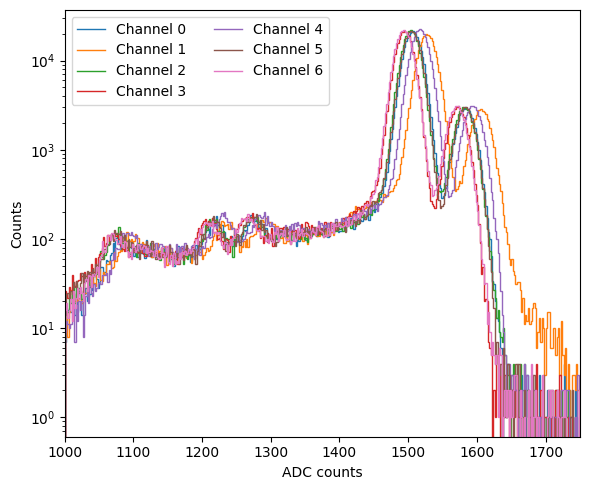

In [3]:
fig = plt.figure(figsize=(6, 5))
ax = fig.subplots()

for i in range(7):
    ax.stairs(weights[i], edges[i], label=f"Channel {i}")

ax.set_xlabel("ADC counts")
ax.set_ylabel("Counts")
ax.set_xlim(edges.min(), edges.max())
ax.set_yscale("log")
ax.legend(loc="upper left", ncol=2)

fig.tight_layout()
fig.savefig("./uncal_en_all.pdf", dpi=300)

### Find peak positions

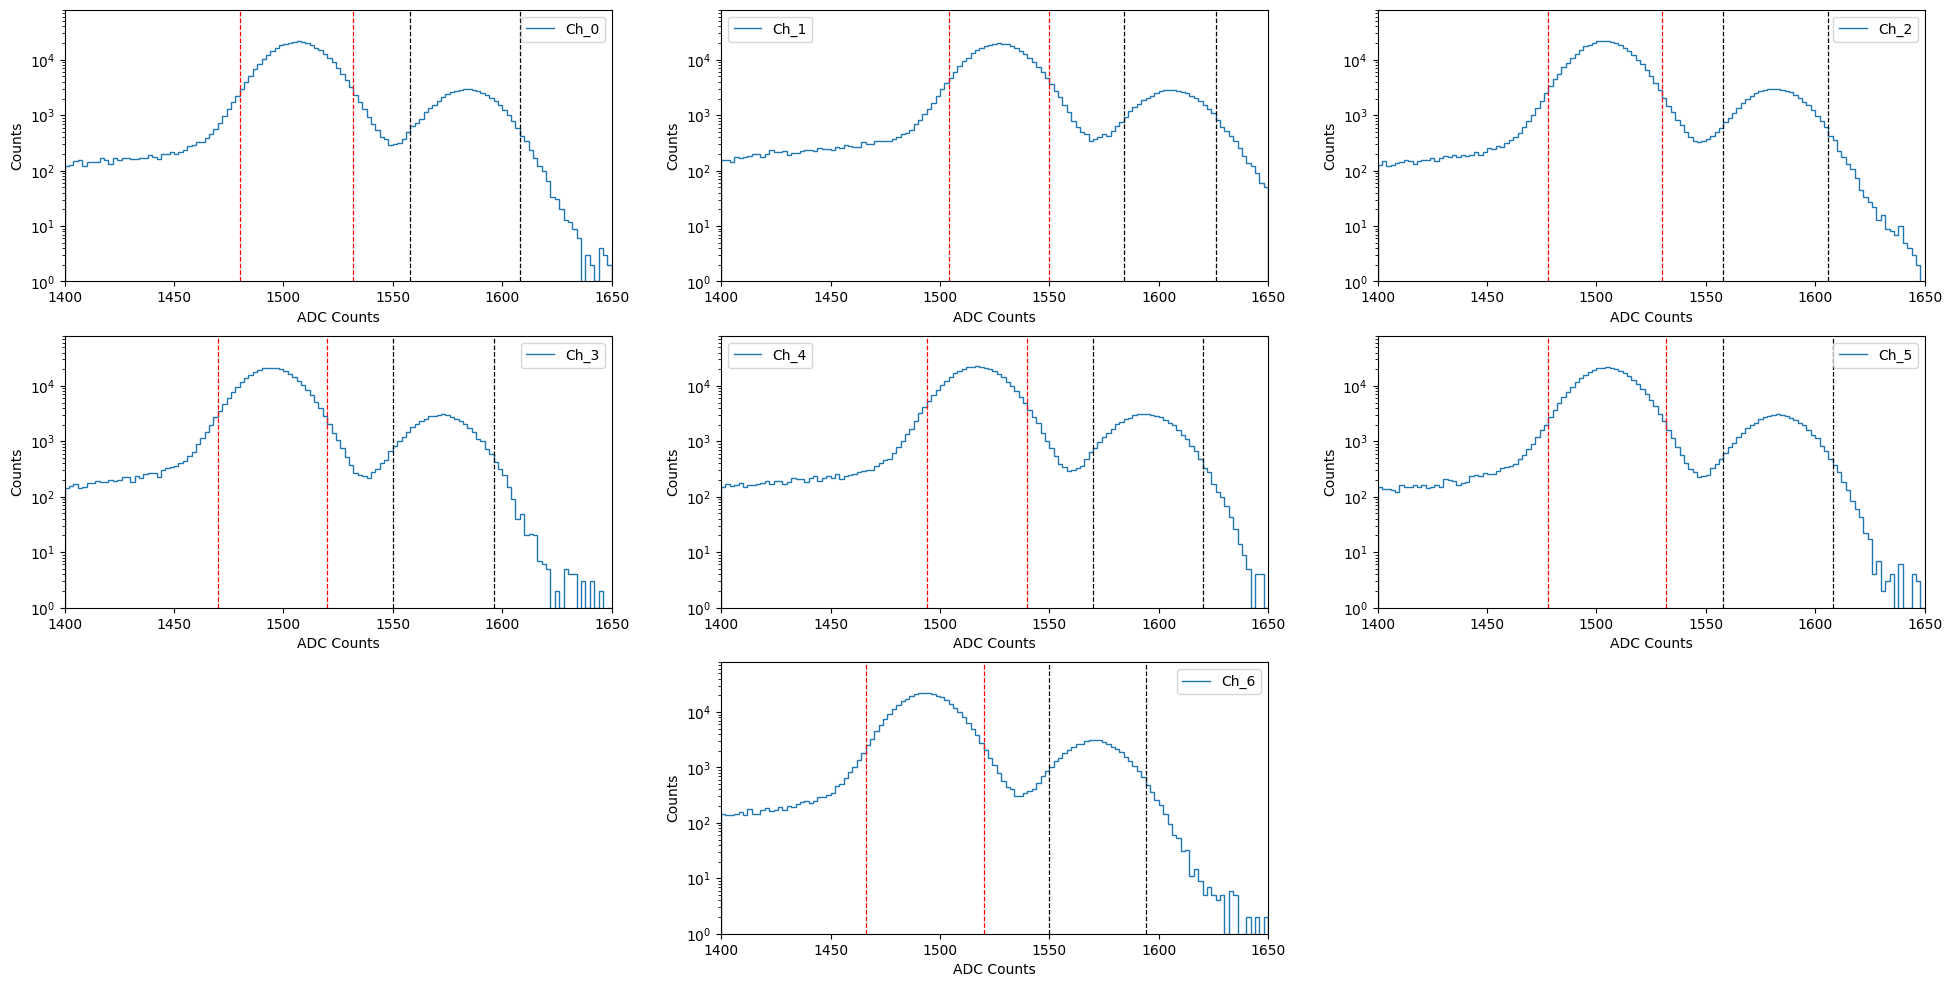

In [4]:
# Determine the intervals for the Gaussian fits
first=np.array([[1480, 1532], [1504, 1550], [1478, 1530],
       [1470, 1520], [1494, 1540], [1478, 1532],
       [1466, 1520]])

second=np.array([[1558, 1608], [1584, 1626], [1558, 1606],
       [1550, 1596], [1570, 1620], [1558, 1608],
       [1550, 1594]])

fig = plt.figure(figsize=(24, 12))
ax = fig.subplots(3, 3)
weights, edges = draw_all_channels(ax, 1, (1400, 1650), 2)
fig.delaxes(ax[-1,-1])
fig.delaxes(ax[-1,-3])

for i in range(7):
    if i == 6:
        ax[-1, -2].set_ylim(1, 8e4)
        for ver in first[i]:
            ax[-1, -2].axvline(ver, ymin=0, ymax=1, color='red', ls='--', lw=0.9)
        for ver in second[i]:
            ax[-1, -2].axvline(ver, ymin=0, ymax=1, color='black', ls='--', lw=0.9) 
    else:
        ax[i//3, i%3].set_ylim(1, 8e4)
        for ver in first[i]:
            ax[i//3, i%3].axvline(ver, ymin=0, ymax=1, color='red', ls='--', lw=0.9)
        for ver in second[i]:
            ax[i//3, i%3].axvline(ver, ymin=0, ymax=1, color='black', ls='--', lw=0.9)

### Gaussian fits

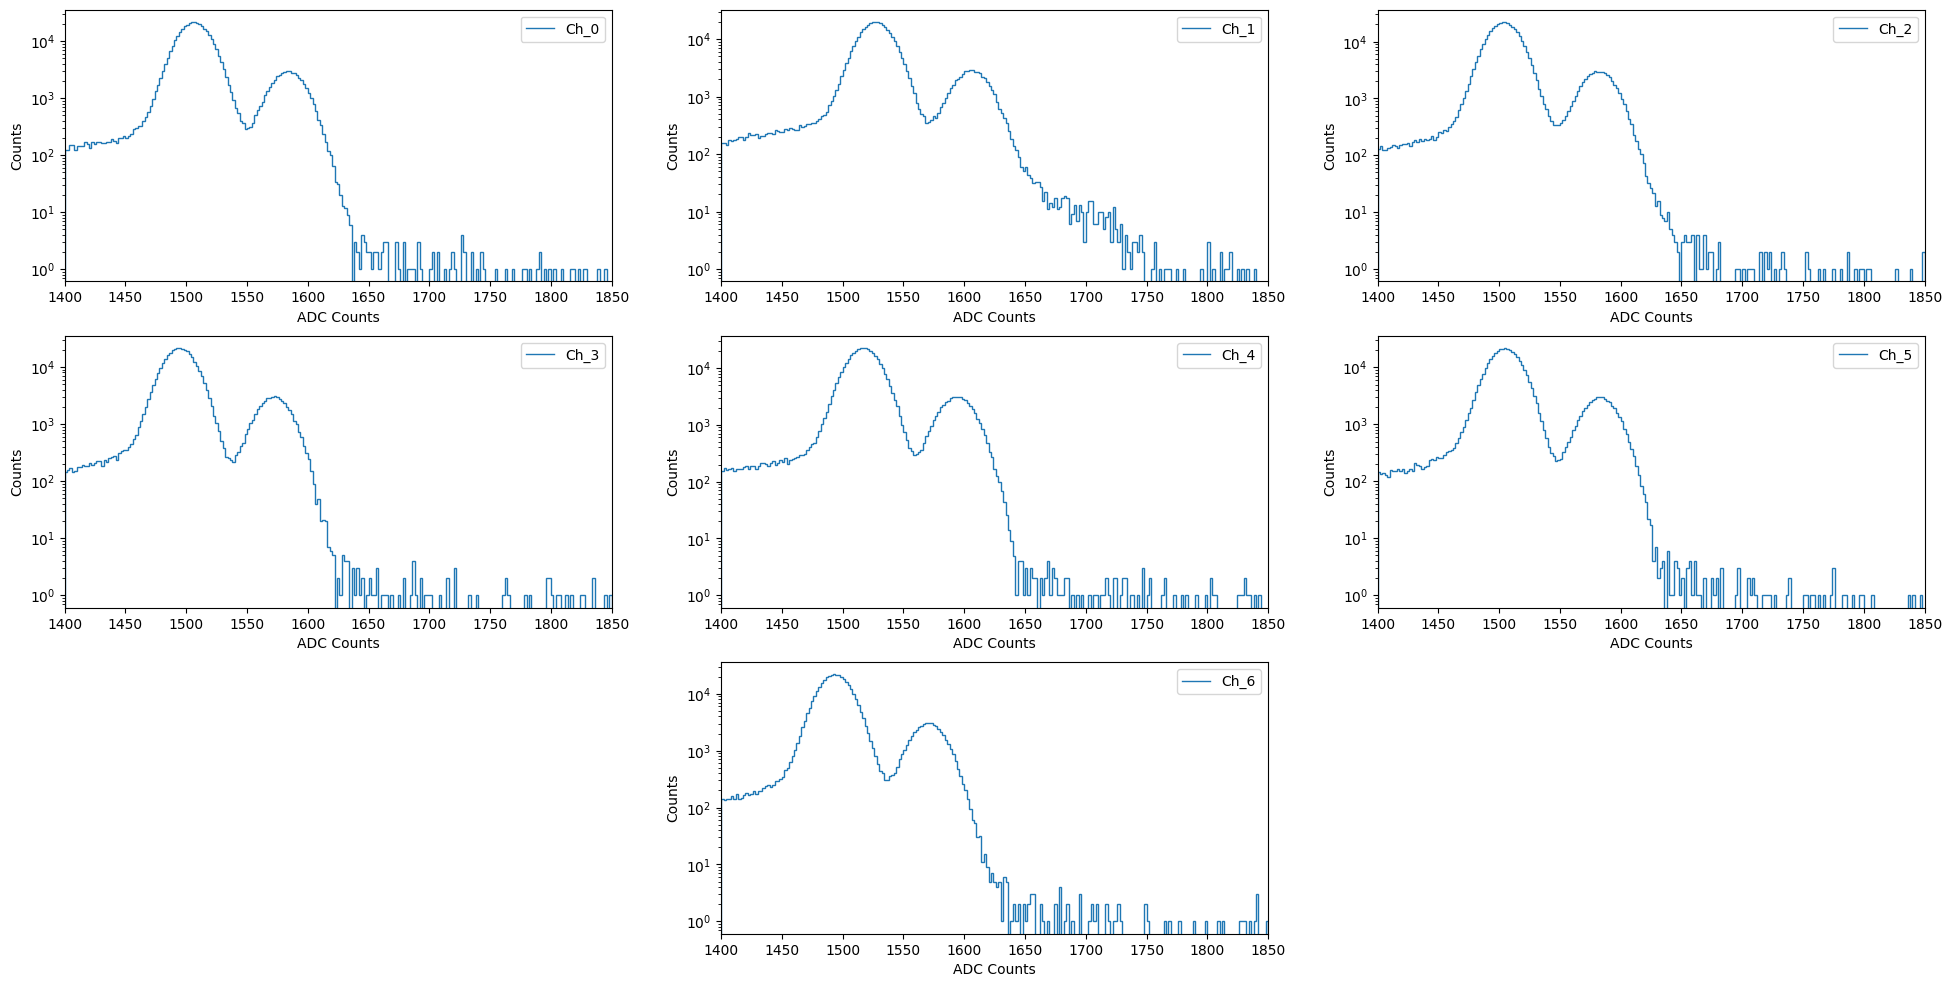

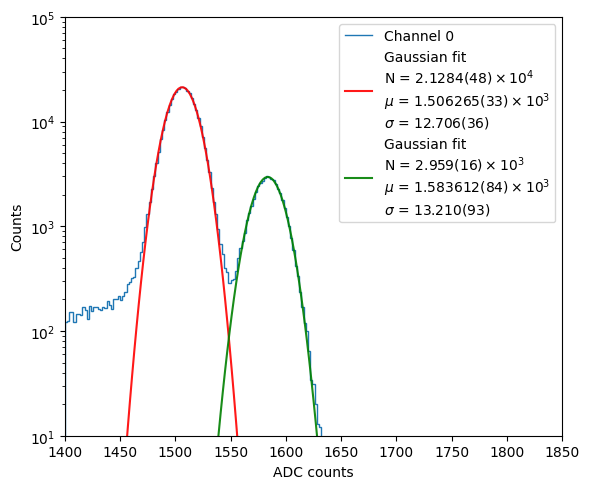

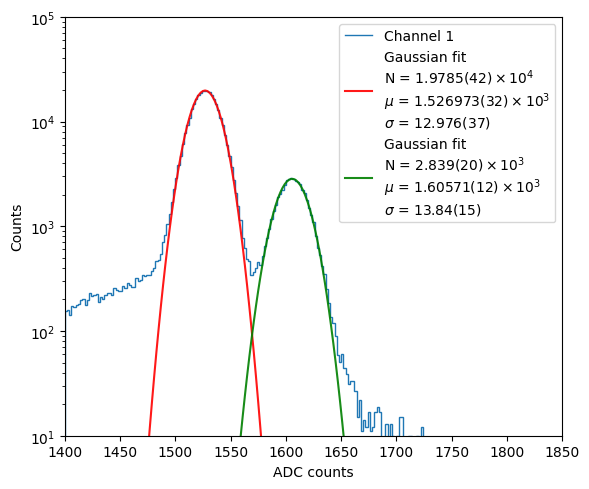

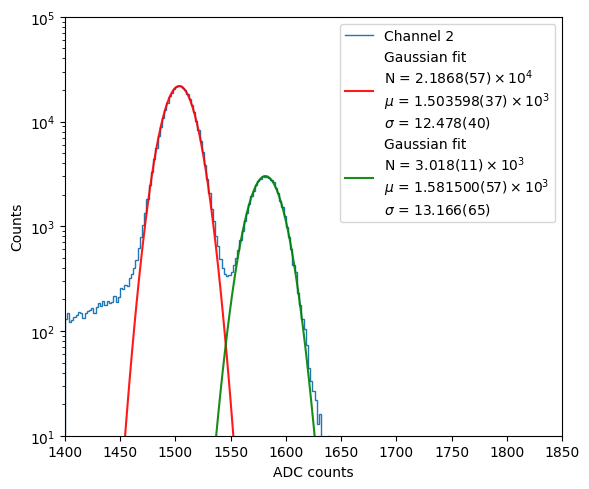

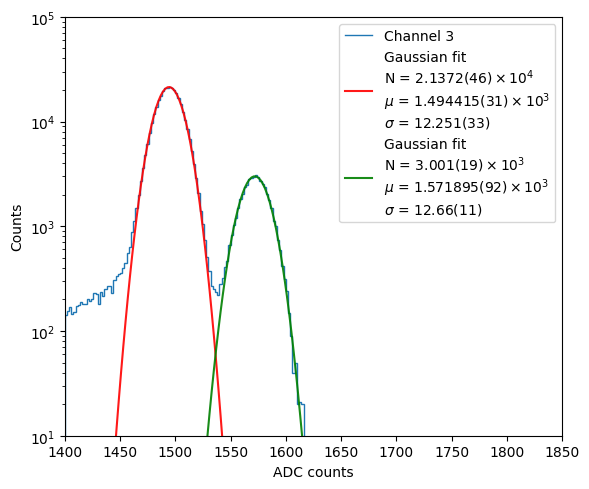

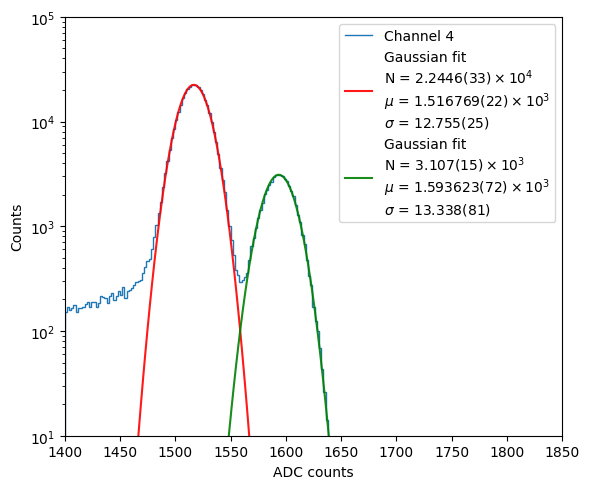

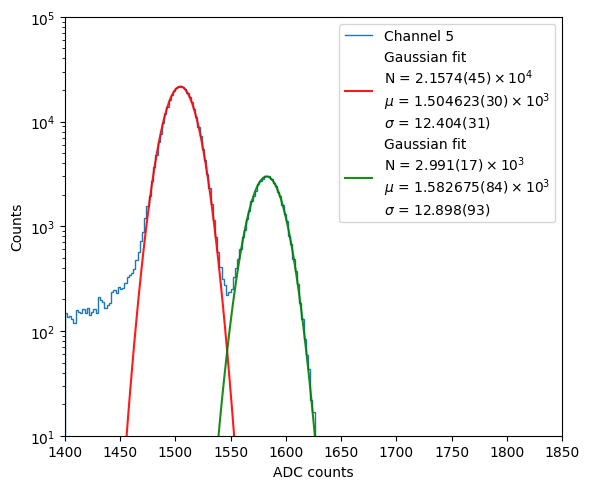

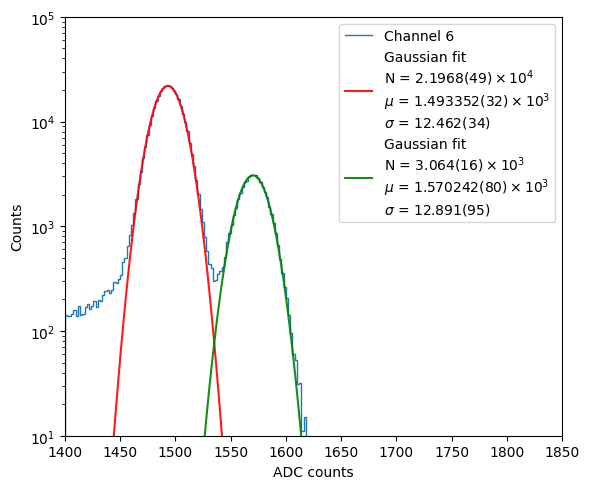

In [5]:
def gaussian(x, a, mu, sig):
    return a*np.exp(-(x-mu)**2/(2*sig**2))

# Optimization parameters and the corresponding errors
popts = {}

# Prepare the histograms
fig = plt.figure(figsize=(24, 12))
ax = fig.subplots(3, 3)
weights, edges = draw_all_channels(ax, 1, (1400, 1850), 2)
fig.delaxes(ax[-1,-1])
fig.delaxes(ax[-1,-3])
weights = np.array(weights)
edges = np.array(edges)
en = (edges[:, 1:] + edges[:, :-1])/2

# Do the gaussian fits on all channels
for i in range(7):
    fit_params = {'popt': [], 'error': []}
    for cut in [first, second]:
        mask=(en[i] > cut[i][0]) & (en[i] <= cut[i][1])
        en_ = en[i][mask]
        weights_ = weights[i][mask]

        weights_=weights_/weights_.max()
        
        start=[1, en_[np.argmax(weights_)], 26]

        popt, perr = curve_fit(gaussian, en_, weights_, p0=start)
        perr = np.sqrt(np.diag(perr))

        fit_params['popt'].append(list(popt))
        fit_params['error'].append(list(perr))
    
    popts[f'ch{i}'] = fit_params

# Produce plots
for i in range(7):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.subplots()

    ax.stairs(weights[i], edges[i], label=f"Channel {i}")
    ax.set_xlabel("ADC counts")
    ax.set_ylabel("Counts")

    for k, cut in enumerate([first, second]):
        params = popts[f'ch{i}']['popt'][k]
        dparams = popts[f'ch{i}']['error'][k]
        a, da = params[0], dparams[0]
        mu, dmu = params[1], dparams[1]
        sig, dsig = params[2], dparams[2]

        mask=(en[i] > cut[i][0]) & (en[i] <= cut[i][1])
        weights_ = weights[i][mask]
        maximum = weights_.max()

        en_ = en[i]
        en_ = en_[(en_ >= mu - 5*sig) * (en_ < mu + 5*sig)]

        if k == 0:
            color = "red"
        elif k == 1:
            color = "green"

        # Scientific notation and uncertainty
        utils.dx = da * maximum
        a_label = "Gaussian fit\nN = {}\n".format(utils.fmt(a * maximum))
        utils.dx = dmu
        mu_label = r"$\mu$" + " = {}\n".format(utils.fmt(mu))
        utils.dx = dsig
        sig_label = r"$\sigma$" + " = {}".format(utils.fmt(sig))

        ax.plot(en_, gaussian(en_, *popts[f'ch{i}']['popt'][k]) * maximum, color=color, alpha=0.9, label=a_label + mu_label + sig_label)

    ax.set_xlim(edges[i].min(), edges[i].max())
    ax.set_yscale("log")
    ax.set_ylim(10, 1e5)
    ax.legend(loc="upper right", ncol=1)

    fig.tight_layout()
    fig.savefig(f'./en_gaussian{i}.pdf', dpi=300)

## "Linear fit"
Calculate the linear parameter for the energy calibration. It is not actually a fit :)

In [6]:
pars = {}
y = np.array([5900, 6490])
for i in range(7):
    mu = np.array(popts[f'ch{i}']['popt'])[:, 1]
    sig = np.array(popts[f'ch{i}']['popt'])[:, 2]

    a = (y[1] - y[0])/(mu[1] - mu[0])
    b = y[0] - a * mu[0]

    # error propagation
    da = a * np.sqrt((sig[0])**2 + (sig[1])**2) / (mu[1] - mu[0])
    db = b * np.sqrt((da / a)**2 + (sig[0] / mu[0])**2)

    pars[f"ch{i}"] = {
        "param": [a, b],
        "error": [da, db]
    }

with open("./calibration.json", "w") as f:
    json.dump(pars, f, indent=4)

### Calibrated spectra

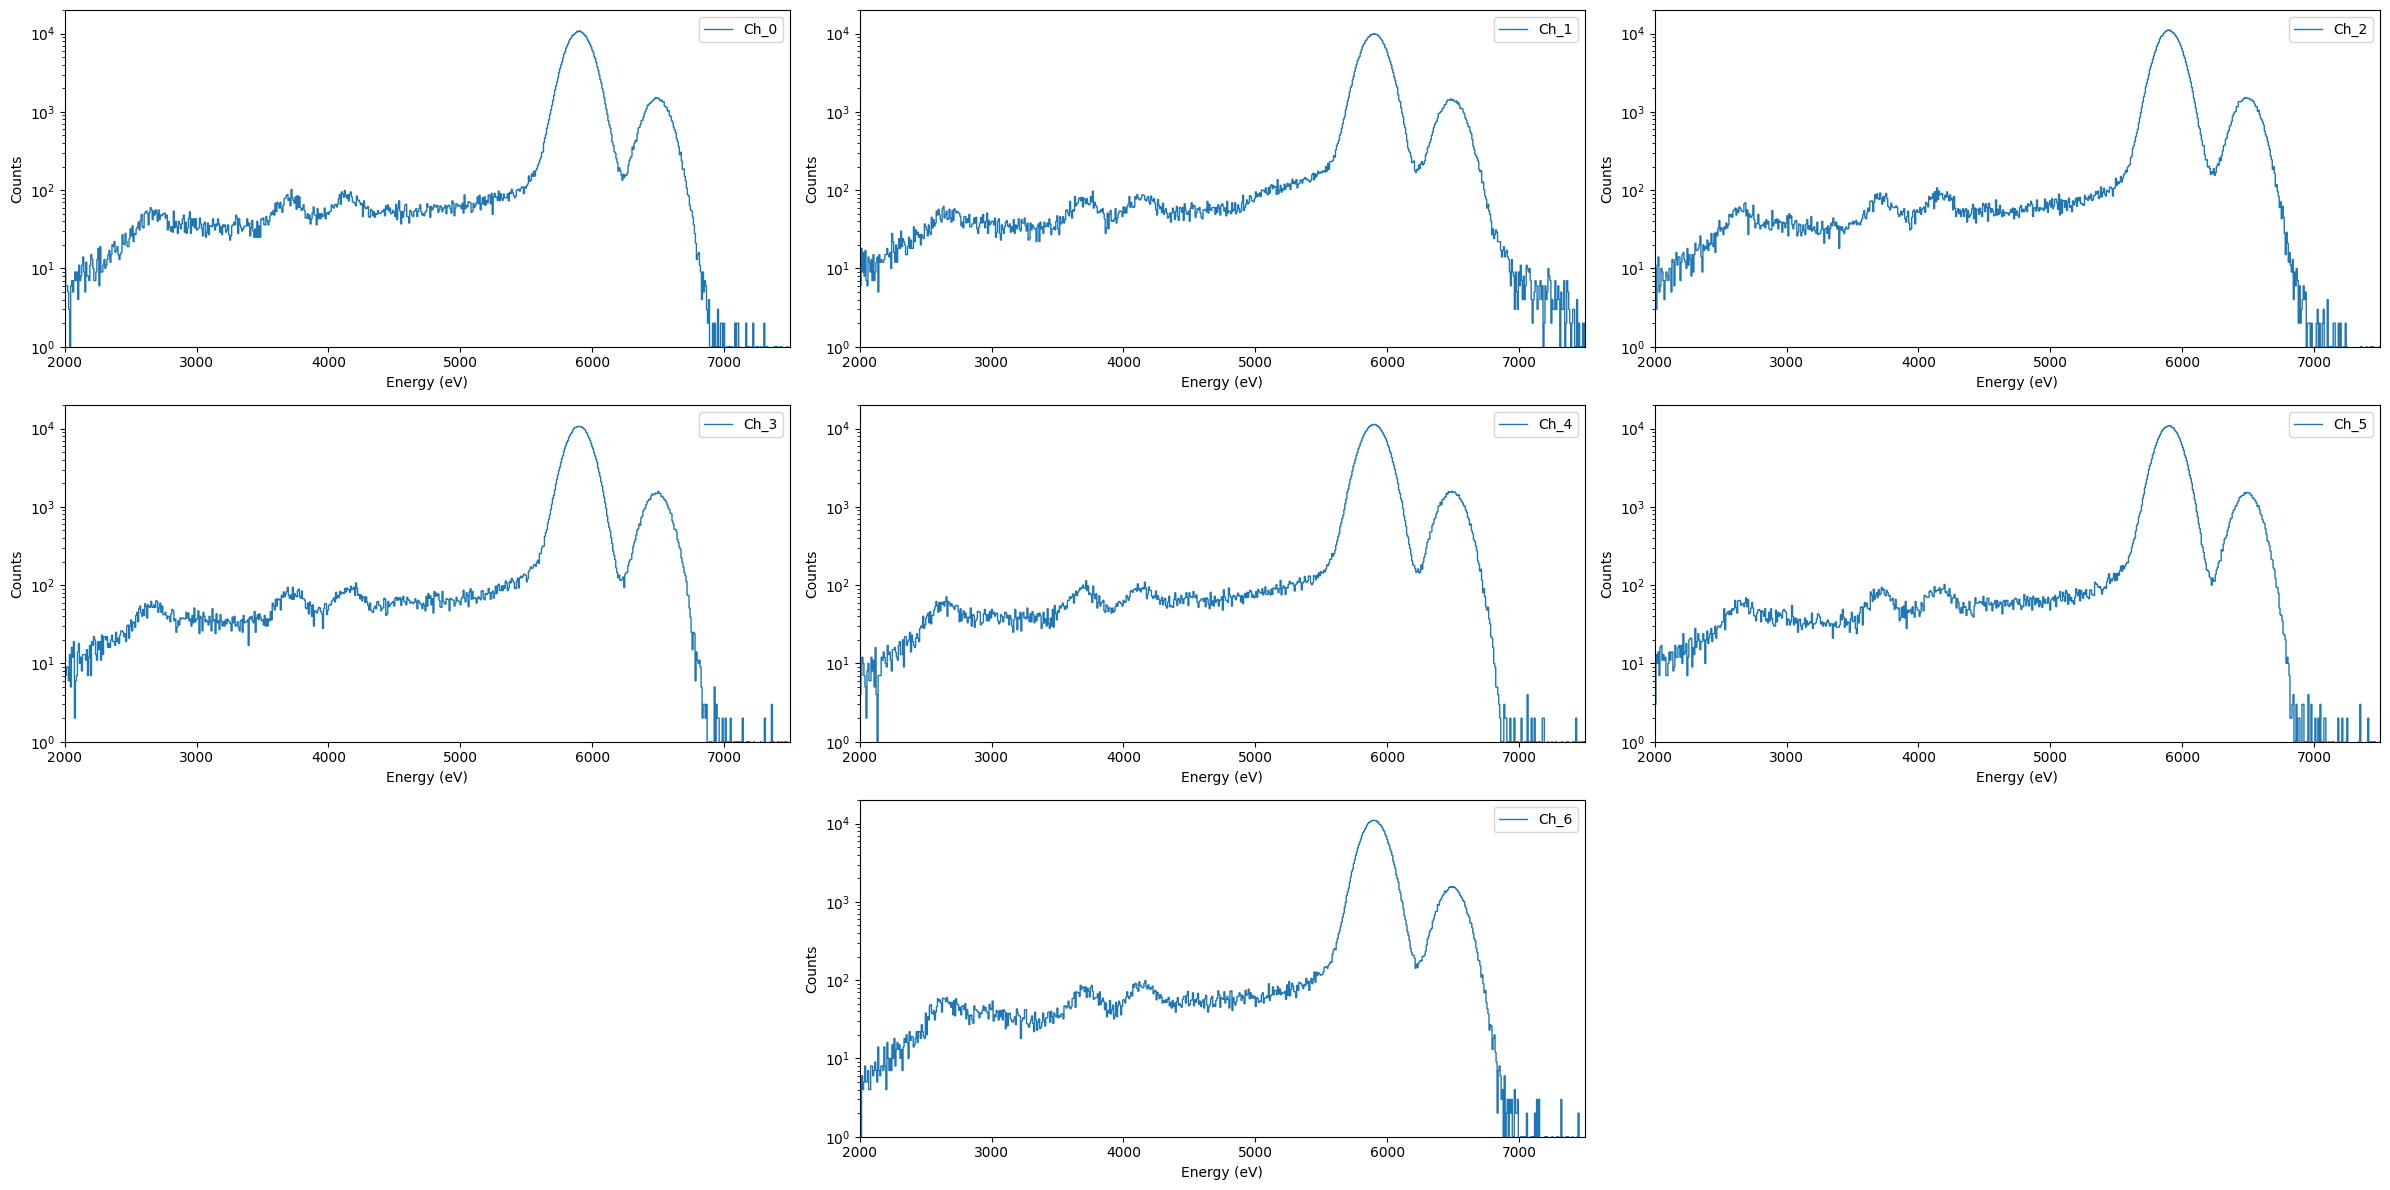

In [7]:
fig = plt.figure(figsize=(24, 12))
ax = fig.subplots(3, 3)

weights, edges = draw_all_channels(ax, 1, (400, 2000), 1, calibration=pars, xlabel="Energy (eV)")
fig.delaxes(ax[-1,-1])
fig.delaxes(ax[-1,-3])

for i in range(6):
    ax[i//3, i%3].set_xlim(2000, 7500)
    ax[i//3, i%3].set_ylim(1, 2e4)
ax[-1, -2].set_xlim(2000, 7500)
ax[-1, -2].set_ylim(1, 2e4)

fig.tight_layout()

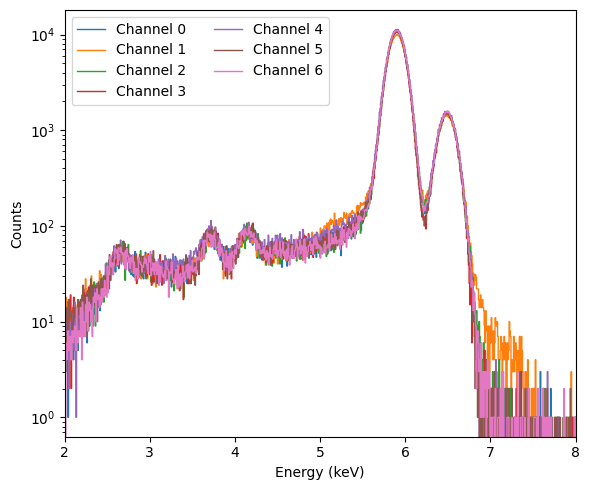

In [8]:
fig = plt.figure(figsize=(6, 5))
ax = fig.subplots()

for i in range(7):
    ax.stairs(weights[i], edges[i] / 1000, label=f"Channel {i}")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")
ax.set_xlim(2, 8)
ax.set_yscale("log")
ax.legend(loc="upper left", ncol=2)

fig.tight_layout()
fig.savefig("./cal_en_all.pdf", dpi=300)

### Energy resolution

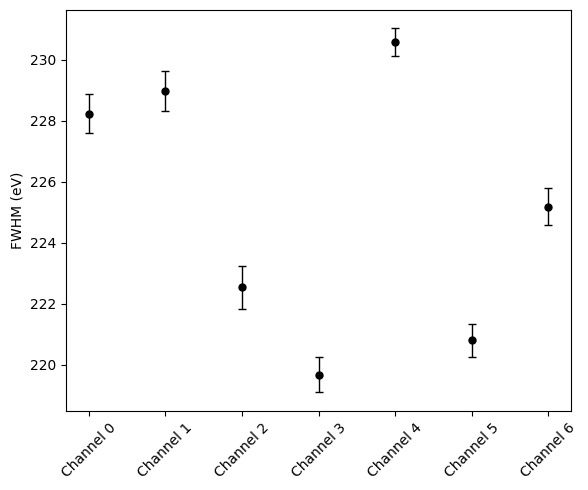

In [9]:
# stds and FWHMs of all channels
sigs = []
dsigs = []
for i in range(7):
    # width
    sig = np.array(popts[f'ch{i}']['popt'])[:, 2]
    sig = sig * pars[f"ch{i}"]["param"][0]
    sigs.append(sig.tolist())
    # uncertainty
    dsig = np.array(popts[f'ch{i}']['error'])[:, 2]
    dsig = dsig * pars[f"ch{i}"]["param"][0]
    dsigs.append(dsig.tolist())

sigs = np.array(sigs) #eV
dsigs = np.array(dsigs) #eV
FWHMs = 2 * np.sqrt(2 * np.log(2)) * sigs #eV
dFWHMs = 2 * np.sqrt(2 * np.log(2)) * dsigs #eV

fig = plt.figure(figsize=(6, 5))
ax = fig.subplots()

ax.errorbar(np.arange(7), FWHMs[:, 0], yerr=dFWHMs[:, 0], fmt='o', color='black', ecolor='black', 
             elinewidth=1, capsize=3, capthick=1, markersize=5)
ax.set_ylabel("FWHM (eV)")

ch_name = [f"Channel {i}" for i in range(7)]
ax.set_xticks(np.arange(7))
ax.set_xticklabels(ch_name, rotation=45)

fig.tight_layout()
fig.savefig("./fwhm.pdf", dpi=300)

### Combined spectrum

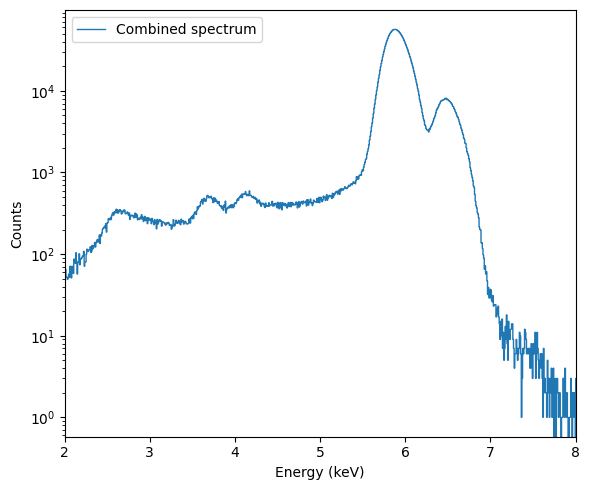

In [11]:
weights_sum = weights.sum(axis=0)
edges_sum = edges[0]

fig = plt.figure(figsize=(6, 5))
ax = fig.subplots()

ax.stairs(weights_sum, edges_sum / 1000, label="Combined spectrum")
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.set_xlim(edges_sum.min() / 1000, edges_sum.max() / 1000)
ax.legend()

ax.set_xlim(2, 8)
fig.tight_layout()
fig.savefig("./combined_spectrum.pdf", dpi=300)